# Impact of climate change on sugar cane yields

95% of Australian sugar cane is produced in Queensland's Northern Coastal areas, where yields depend on wet, rainy summers.

This notebook will attempt to answer the question of climate change impacts on Australia's $2B sugar export industry, through the following steps:

- Obtain weather and yield data for existing sugar mills
- Construct a model to predict high and low sugar cane yield years, from the weather
- Use predictive climate models to predict the weather for these sites in 2040
- Assess the expected change in yields for these sites 

Sugar mills range down Queensland's Eastern coast. An initial hypothesis is that more Southerly mills will see increased yields, while more Northerly mills may be adversely affected.

## Data used

Data will be ingested from the [Open Meteo API](https://open-meteo.com/) using the prepared `queryscripts` library used to fetch weather for other analysis in this project. The Open Meteo [Climate Change API](https://open-meteo.com/en/docs/climate-api) will also be used.

Sugar Cane yield data will be obtained from the [Australian Sugar Milling Council](https://asmc.com.au/policy-advocacy/sugar-industry-overview/statistics/), and spans years 2014 to 2021.


## Data fields

The following weather data will be obtained for history and a 2040 forecast:

- Maximum daily temperatures
- Minimum daily temperatures
- Mean relative humidity (aggregated from hourly)
- Evaporation (Evapotranspiration)
- Precipitation
- Shortwave Radiation Sum

2040 forecasts will use the [EC-Earth3 climate model](https://ec-earth.org/ec-earth/ec-earth3/)

This will be compared to tons of sugar produced per hectare harvested.


## Methodology

A linear discriminant function analysis will be employed, loosely following the methodology published in [Priya et al 2022](https://www.sciencedirect.com/science/article/pii/S2772375522000417). The methodology will differ in applying the regression across multiple regions and not applying an iterative fitting approach.

Note that the sugar cane harvesting Season is from July to November, so the natural calendar year will be used to associate weather data to yields.



## Obtaining data

In [1]:
# imports
import numpy as np
import pandas as pd
import hvplot.pandas
import queryscripts as qs
import datetime
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# locations and dates

dates = ['2014-01-01','2021-12-31']
future_dates = ['2040-01-01','2044-12-31']

locations = {
  'Mossman Mill': [-16.458395872325614, 145.37872247775334],
  'MSF Sugar Limited': [-17.09463834097625, 145.79106277184627],
  'Tableland Mill': [-17.12092412176469, 145.3451993546147],
  'Tully Sugar Mill': [-17.938238362823032, 145.92697472573207],
  'Victoria Sugar': [-18.65171457481504, 146.2025221767285],
  'Mackay Sugar': [-21.17084887130307, 149.1337541354953],
  'Bundaberg Sugar': [-24.93537351906151, 152.1951097012406],
  'Wilmar Inkerman Mill': [-19.646131289571432, 147.3986836111172],
  'Isis Central Sugar Mill': [-25.197550386863465, 152.20661236023415]
}

mapdf = pd.DataFrame(list(locations.values()), columns=['latitude', 'longitude'], index=locations.keys())

plot = mapdf.hvplot.points(
  'longitude',
  'latitude',
  geo = True,
  tiles = 'EsriTerrain',
  xlim = (140,154),
  ylim = (-14,-30),
)

plot


:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [longitude,latitude]

In [3]:
# historical weather data

historical_weather_df = pd.DataFrame()

for location in locations: 
  loc_weather_data = qs.get_openmeteo_data(*locations[location],*dates,'weather')
  loc_humidity_data = qs.agg_hourly_weather_data(*locations[location],*dates,'relativehumidity_2m')
  loc_data = pd.merge(loc_weather_data,loc_humidity_data[['date','relativehumidity_2m']],on=['date'])
  loc_data.insert(1,'location',str(location))
  historical_weather_df = pd.concat([historical_weather_df, loc_data], ignore_index=True)
  print("Data retrieved for "+location)


historical_weather_df


Data retrieved for Mossman Mill
Data retrieved for MSF Sugar Limited
Data retrieved for Tableland Mill
Data retrieved for Tully Sugar Mill
Data retrieved for Victoria Sugar
Data retrieved for Mackay Sugar
Data retrieved for Bundaberg Sugar
Data retrieved for Wilmar Inkerman Mill
Data retrieved for Isis Central Sugar Mill


,date,location,latitude,longitude,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,precipitation_hours,windspeed_10m_max,et0_fao_evapotranspiration,shortwave_radiation_sum,relativehumidity_2m
0,2014-01-01,Mossman Mill,-16.458396,145.378722,32.2,24.3,27.3,0.0,0.0,18.2,6.19,29.68,94
1,2014-01-01,Mossman Mill,-16.458396,145.378722,32.2,24.3,27.3,0.0,0.0,18.2,6.19,29.68,94
2,2014-01-01,Mossman Mill,-16.458396,145.378722,32.2,24.3,27.3,0.0,0.0,18.2,6.19,29.68,96
3,2014-01-01,Mossman Mill,-16.458396,145.378722,32.2,24.3,27.3,0.0,0.0,18.2,6.19,29.68,96
4,2014-01-01,Mossman Mill,-16.458396,145.378722,32.2,24.3,27.3,0.0,0.0,18.2,6.19,29.68,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...
631147,2021-12-31,Isis Central Sugar Mill,-25.197550,152.206612,24.0,20.6,22.0,5.6,14.0,23.4,2.50,8.29,90
631148,2021-12-31,Isis Central Sugar Mill,-25.197550,152.206612,24.0,20.6,22.0,5.6,14.0,23.4,2.50,8.29,91
631149,2021-12-31,Isis Central Sugar Mill,-25.197550,152.206612,24.0,20.6,22.0,5.6,14.0,23.4,2.50,8.29,91
631150,2021-12-31,Isis Central Sugar Mill,-25.197550,152.206612,24.0,20.6,22.0,5.6,14.0,23.4,2.50,8.29,90


In [4]:
# future weather data (2040)

future_weather_df = pd.DataFrame()

for location in locations: 
  loc_weather_data = qs.get_openmeteo_data(*locations[location],*future_dates,'climate change')
  loc_weather_data.insert(1,'location',str(location))
  future_weather_df = pd.concat([future_weather_df, loc_weather_data], ignore_index=True)
  print("Data retrieved for "+location)

future_weather_df.rename(columns = {
  'et0_fao_evapotranspiration_sum': 'et0_fao_evapotranspiration',
  'relative_humidity_2m_mean': 'relativehumidity_2m'
}, inplace = True)

future_weather_df

Data retrieved for Mossman Mill
Data retrieved for MSF Sugar Limited
Data retrieved for Tableland Mill
Data retrieved for Tully Sugar Mill
Data retrieved for Victoria Sugar
Data retrieved for Mackay Sugar
Data retrieved for Bundaberg Sugar
Data retrieved for Wilmar Inkerman Mill
Data retrieved for Isis Central Sugar Mill


,date,location,latitude,longitude,temperature_2m_max,temperature_2m_min,shortwave_radiation_sum,relativehumidity_2m,precipitation_sum,et0_fao_evapotranspiration
0,2040-01-01,Mossman Mill,-16.458396,145.378722,32.3,28.5,18.79,82,5.02,4.06
1,2040-01-02,Mossman Mill,-16.458396,145.378722,33.4,27.7,21.61,80,0.61,4.45
2,2040-01-03,Mossman Mill,-16.458396,145.378722,34.6,27.8,24.24,83,2.05,5.35
3,2040-01-04,Mossman Mill,-16.458396,145.378722,33.3,27.1,23.75,88,9.33,5.53
4,2040-01-05,Mossman Mill,-16.458396,145.378722,31.8,26.3,20.94,89,5.43,4.74
...,...,...,...,...,...,...,...,...,...,...
16438,2044-12-27,Isis Central Sugar Mill,-25.197550,152.206612,30.9,21.7,25.04,62,0.09,5.20
16439,2044-12-28,Isis Central Sugar Mill,-25.197550,152.206612,28.8,21.3,19.11,63,0.95,3.87
16440,2044-12-29,Isis Central Sugar Mill,-25.197550,152.206612,25.1,20.6,9.85,75,2.06,1.91
16441,2044-12-30,Isis Central Sugar Mill,-25.197550,152.206612,24.2,20.5,8.20,89,56.44,1.57


In [5]:
raw_yield_data = pd.read_csv('Data/sugar_raw_yield_data.csv')

raw_yield_data

,Value,Region,2014,2015,2016,2017,2018,2019,2020,2021
0,hectares_harvested,Northern,82187,80549,84247,80844,80207,78098,77346,76504
1,hectares_harvested,Herbert-Burdekin,126963,127064,124922,125878,125908,124190,121426,120491
2,hectares_harvested,Mackay-Proserpine,107702,107863,100407,105140,108001,106464,103940,101054
3,hectares_harvested,Southern,46486,49684,45896,46096,48298,41330,37902,31067
4,cane_crushed,Northern,6634943,7636039,7882048,6903568,6666625,5881737,6481857,6205146
5,cane_crushed,Herbert-Burdekin,12213695,12737984,13522425,13154061,12741351,11964772,12155491,11684926
6,cane_crushed,Mackay-Proserpine,8555987,8010564,8905999,7578885,7375712,7744491,7921554,8258828
7,cane_crushed,Southern,3411638,4269951,4096086,3835027,3705045,2852049,2771433,2363978
8,sugar_produced,Northern,864441,969829,938631,879936,959771,775157,854451,766203
9,sugar_produced,Herbert-Burdekin,1774250,1872298,1840860,1819406,1908359,1784220,1763709,1658710


In [6]:

raw_yield_data = pd.read_csv('Data/sugar_raw_yield_data.csv')

# Reshape the dataframe into a tidy format
df_melted = raw_yield_data.melt(id_vars=["Value", "Region"], 
  var_name="Year", 
  value_name="Amount")

df_pivot = df_melted.pivot_table(index=["Region", "Year"], 
  columns="Value", 
  values="Amount").reset_index()

df_pivot.columns.name = None
df_pivot.columns = [col.lower() for col in df_pivot.columns]

production_df = df_pivot[['year', 'region', 'hectares_harvested', 'cane_crushed', 'sugar_produced']]

production_df['yield'] = production_df.sugar_produced/production_df.hectares_harvested*1000 # tons of sugar per hectare

production_df


,year,region,hectares_harvested,cane_crushed,sugar_produced,yield
0,2014,Herbert-Burdekin,126963,12213695,1774250,13974.543765
1,2015,Herbert-Burdekin,127064,12737984,1872298,14735.078386
2,2016,Herbert-Burdekin,124922,13522425,1840860,14736.075311
3,2017,Herbert-Burdekin,125878,13154061,1819406,14453.725035
4,2018,Herbert-Burdekin,125908,12741351,1908359,15156.773199
5,2019,Herbert-Burdekin,124190,11964772,1784220,14366.857235
6,2020,Herbert-Burdekin,121426,12155491,1763709,14524.969941
7,2021,Herbert-Burdekin,120491,11684926,1658710,13766.256401
8,2014,Mackay-Proserpine,107702,8555987,1235077,11467.540064
9,2015,Mackay-Proserpine,107863,8010564,1169360,10841.159619


In [7]:
# save data

historical_weather_df.to_csv('Data/sugar_weather_history.csv', index=False)

future_weather_df.to_csv('Data/sugar_weather_future.csv', index=False)

production_df.to_csv('Data/sugar_production.csv', index=False)


## Data preparation for modelling

Following the methodology, we'll need to calculate the residuals from a linear regression of year-on-year yields. We can go further as we have the region-based yields and weather information. The residuals will be used to split the location-years into 'high' and 'low' categories.

Sugar cane is ratooned three times, with the first three harvests leaving the stem to regrow, being fully uprooted when harvested in the fourth year. However as the growth associated with each year's harvest is is mostly due to conditions over the previous 12 months, only this period will be accounted for.

To obtain the joined dataset, weather data will be compiled into thirds of the year (two growing thirds, and a harvesting third). Mills will be mapped to their respective regions.

In [8]:
# select desired columns and create region_year key for yields

production_df['region_year'] = production_df['region']+'-'+production_df['year']

yields_df = production_df[['region_year','yield']]

yields_df.head()

,region_year,yield
0,Herbert-Burdekin-2014,13974.543765
1,Herbert-Burdekin-2015,14735.078386
2,Herbert-Burdekin-2016,14736.075311
3,Herbert-Burdekin-2017,14453.725035
4,Herbert-Burdekin-2018,15156.773199


In [9]:
# join future weather to current weather

fdf = future_weather_df.rename(columns = {
  'et0_fao_evapotranspiration_sum': 'et0_fao_evapotranspiration',
  'relative_humidity_2m_mean': 'relativehumidity_2m'
})

weather = fdf.append(historical_weather_df)


In [10]:
# select desired columns and create region_year key for weather

# map mills onto regions

mill_mapping = {
  'Mossman Mill': 'Northern',
  'MSF Sugar Limited': 'Northern',
  'Tableland Mill': 'Northern',
  'Tully Sugar Mill': 'Herbert-Burdekin',
  'Victoria Sugar': 'Herbert-Burdekin',
  'Mackay Sugar': 'Mackay-Proserpine',
  'Bundaberg Sugar': 'Southern',
  'Wilmar Inkerman Mill': 'Herbert-Burdekin',
  'Isis Central Sugar Mill': 'Southern'
}

weather['region'] = weather['location'].map(mill_mapping)

# compute thirds and years

weather['third'] = weather['date'].apply(lambda dt: 'T'+str((datetime.datetime.strptime(dt, "%Y-%m-%d").month-1)//4+1))
weather['year'] = weather['date'].apply(lambda dt: (datetime.datetime.strptime(dt, "%Y-%m-%d").year))

weather = weather[['year','third','region','temperature_2m_max','temperature_2m_min','relativehumidity_2m','et0_fao_evapotranspiration','precipitation_sum','shortwave_radiation_sum']]

# pivot to construct model inputs

weather_grouped = weather.groupby(['year','third','region']).mean()

weather_unstacked = weather_grouped.unstack(level='third')

weather_unstacked.columns = ['_'.join(str(i) for i in col) for col in weather_unstacked.columns]

weather_df = weather_unstacked.reset_index()

# create join key 

weather_df['region_year'] = weather_df['region']+'-'+weather_df['year'].astype('str')


weather_df.head()

,year,region,temperature_2m_max_T1,temperature_2m_max_T2,temperature_2m_max_T3,temperature_2m_min_T1,temperature_2m_min_T2,temperature_2m_min_T3,relativehumidity_2m_T1,relativehumidity_2m_T2,...,et0_fao_evapotranspiration_T1,et0_fao_evapotranspiration_T2,et0_fao_evapotranspiration_T3,precipitation_sum_T1,precipitation_sum_T2,precipitation_sum_T3,shortwave_radiation_sum_T1,shortwave_radiation_sum_T2,shortwave_radiation_sum_T3,region_year
0,2014,Herbert-Burdekin,28.094722,23.210298,28.515847,23.013333,16.985095,21.133333,82.928588,78.785569,...,3.826528,2.825447,5.115601,7.070833,1.500542,0.680055,18.524583,14.813008,24.648607,Herbert-Burdekin-2014
1,2014,Mackay-Proserpine,27.461667,22.539024,27.483607,22.817500,15.698374,20.540984,79.453819,74.534553,...,4.155833,3.054959,5.236639,8.671667,1.317073,0.793443,18.982583,14.762602,24.627705,Mackay-Proserpine-2014
2,2014,Northern,28.048611,23.645528,28.294262,22.766667,17.437669,20.259016,84.250116,80.771229,...,3.654056,2.912981,5.159399,7.935556,1.149864,0.387158,17.968250,15.361409,25.095164,Northern-2014
3,2014,Southern,28.708333,22.185772,28.200820,20.380417,12.636585,17.643852,71.652257,69.106877,...,4.486708,2.828374,4.883074,3.012500,0.647561,2.005328,19.576042,13.944837,23.167910,Southern-2014
4,2015,Herbert-Burdekin,29.781111,24.101897,27.657923,23.706389,17.711111,21.484699,79.453356,77.427507,...,4.458250,2.982114,4.637186,3.826111,1.226016,1.961475,20.967083,14.941328,22.200738,Herbert-Burdekin-2015


In [11]:
df = pd.merge(yields_df,weather_df,on=['region_year'],how='outer')

df.head()

,region_year,yield,year,region,temperature_2m_max_T1,temperature_2m_max_T2,temperature_2m_max_T3,temperature_2m_min_T1,temperature_2m_min_T2,temperature_2m_min_T3,...,relativehumidity_2m_T3,et0_fao_evapotranspiration_T1,et0_fao_evapotranspiration_T2,et0_fao_evapotranspiration_T3,precipitation_sum_T1,precipitation_sum_T2,precipitation_sum_T3,shortwave_radiation_sum_T1,shortwave_radiation_sum_T2,shortwave_radiation_sum_T3
0,Herbert-Burdekin-2014,13974.543765,2014,Herbert-Burdekin,28.094722,23.210298,28.515847,23.013333,16.985095,21.133333,...,73.328438,3.826528,2.825447,5.115601,7.070833,1.500542,0.680055,18.524583,14.813008,24.648607
1,Herbert-Burdekin-2015,14735.078386,2015,Herbert-Burdekin,29.781111,24.101897,27.657923,23.706389,17.711111,21.484699,...,75.674408,4.458250,2.982114,4.637186,3.826111,1.226016,1.961475,20.967083,14.941328,22.200738
2,Herbert-Burdekin-2016,14736.075311,2016,Herbert-Burdekin,29.687603,24.278591,28.616120,23.763636,18.566667,22.109290,...,76.618739,4.328017,2.781382,4.790464,5.102755,2.598103,1.231148,20.665895,14.268672,23.024863
3,Herbert-Burdekin-2017,14453.725035,2017,Herbert-Burdekin,29.271111,24.050678,27.910656,23.607778,17.830352,21.503552,...,77.016621,4.170000,2.900298,4.668934,5.986667,1.551762,1.976230,20.002417,14.994526,22.766940
4,Herbert-Burdekin-2018,15156.773199,2018,Herbert-Burdekin,28.813889,24.084553,28.950000,23.220278,16.952575,21.851639,...,75.901639,4.009333,3.115989,4.771093,8.360000,0.604336,4.676776,19.193500,15.852060,22.615929


## Modelling the data

First, we compute the residuals to find under-performing and over-performing region-years. Then we fit the LDA model.


In [12]:
df0 = df[-df['region_year'].str.contains("204")] # data for fitting model (minus the future data)
df1 = df[df['region_year'].str.contains("204")]

independent_vars = df.copy().columns.tolist()[4:]

independent_vars

['temperature_2m_max_T1',
 'temperature_2m_max_T2',
 'temperature_2m_max_T3',
 'temperature_2m_min_T1',
 'temperature_2m_min_T2',
 'temperature_2m_min_T3',
 'relativehumidity_2m_T1',
 'relativehumidity_2m_T2',
 'relativehumidity_2m_T3',
 'et0_fao_evapotranspiration_T1',
 'et0_fao_evapotranspiration_T2',
 'et0_fao_evapotranspiration_T3',
 'precipitation_sum_T1',
 'precipitation_sum_T2',
 'precipitation_sum_T3',
 'shortwave_radiation_sum_T1',
 'shortwave_radiation_sum_T2',
 'shortwave_radiation_sum_T3']

In [13]:
# linear regression to obtain residuals

lr = LinearRegression()
lr.fit(df0[independent_vars], df0['yield'])

df0['residuals'] = df0['yield'] - lr.predict(df0[independent_vars])

df0['group'] = np.where(df0['residuals'] < 0, 0, 1) # 0 for underperforming, 1 for overperforming


In [14]:
# fit the LDA model to dimensionally reduce the weather data

lda_model = LinearDiscriminantAnalysis()

X = df0[independent_vars]
y = df0['group']

lda_model.fit(X,y)

df0['lda_score'] = lda_model.transform(X)

# fit linear model with the LDA score

lr = LinearRegression()
lr.fit(df0[['lda_score']], df0['yield'])

df0['yield_predicted'] = lr.predict(df0[['lda_score']])


In [15]:
df1['lda_score'] = lda_model.transform(df1[independent_vars])

df1['yield_predicted'] = lr.predict(df1[['lda_score']])

final_df = df0[['year','region','yield','yield_predicted']].append(df1[['year','region','yield_predicted']])

final_df

,year,region,yield,yield_predicted
0,2014,Herbert-Burdekin,13974.543765,11943.061500
1,2015,Herbert-Burdekin,14735.078386,11893.504680
2,2016,Herbert-Burdekin,14736.075311,12008.864360
3,2017,Herbert-Burdekin,14453.725035,11752.372945
4,2018,Herbert-Burdekin,15156.773199,11690.949836
5,2019,Herbert-Burdekin,14366.857235,11919.156764
6,2020,Herbert-Burdekin,14524.969941,11673.501612
7,2021,Herbert-Burdekin,13766.256401,11772.481653
8,2014,Mackay-Proserpine,11467.540064,11829.778764
9,2015,Mackay-Proserpine,10841.159619,11637.242196


## Evaluation of results



In [16]:
ydf = final_df.copy()

ydf['Combined Yield'] =  ydf['yield'].fillna(ydf['yield_predicted'])

years = ydf.groupby('year').sum()['Combined Yield']

years

year
2014    46592.337509
2015    50139.459650
2016    50185.669247
2017    46631.576357
2018    48257.666214
2019    44870.902733
2020    46273.011188
2021    45970.591368
2040    47497.509668
2041    44507.394894
2042    47085.442686
2043    51767.265572
2044    46361.136981
Name: Combined Yield, dtype: float64

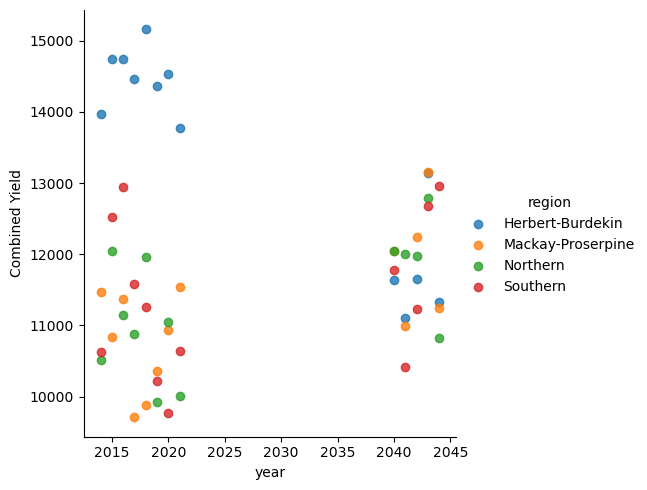

In [17]:

plot = sns.lmplot(data=ydf, x='year', y='Combined Yield', hue='region', fit_reg=False, legend=True)

The regression predicts the convergence of yields, with the current highest-performing region, 'Herbert-Burdekin', south of Townsville, dropping while other regions further to the South or North increase. The net effect is not a significant decrease in overall yields.